In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
import os 
os.chdir('drive/My Drive/Home_Credit_Default_Risk')

## Project Details

### **Description**
Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit Group

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

### **Evaluation**
Submissions are evaluated on **area under the ROC curve** between the predicted probability and the observed target.


### **Expectd result is near 0.80 roc auc**

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import os


In [0]:
"""pos_cash = pd.read_csv('POS_CASH_balance.csv')
installments = pd.read_csv('installments_payments.csv')
credit_card = pd.read_csv('credit_card_balance.csv')
bureau = pd.read_csv('bureau.csv')
b_balance = pd.read_csv('bureau_balance.csv')"""
application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')
#prev_appl = pd.read_csv('previous_application.csv')

In [0]:
print('pos_cash shape: ',pos_cash.shape)
print('installments shape: ',installments.shape)
print('credit_card shape: ',credit_card.shape)
print('bureau shape: ',bureau.shape)
print('b_balance shape: ',b_balance.shape)
print('Training data shape: ',application_train.shape)
print('Test data shape: ',application_test.shape)
print('prev_appl shape: ',prev_appl.shape)

pos_cash shape:  (10001358, 8)
installments shape:  (13605401, 8)
credit_card shape:  (3840312, 23)
bureau shape:  (1716428, 17)
b_balance shape:  (27299925, 3)
Training data shape:  (307511, 240)
Test data shape:  (48744, 239)
prev_appl shape:  (1670214, 37)


In [0]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [0]:
num_rows = None
df = application_train_test(num_rows)

bureau = bureau_and_balance(num_rows)
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau
gc.collect()

prev = previous_applications(num_rows)
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev
gc.collect()

pos = pos_cash(num_rows)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos
gc.collect()

ins = installments_payments(num_rows)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins
gc.collect()

cc = credit_card_balance(num_rows)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc
gc.collect()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)


0

In [0]:
print(df.shape)
df.head()

(356251, 798)


,index,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,...,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0247,0.0250,0.0252,0.0369,0.0369,0.0383,0,1.0,0,0.0143,0.0144,0.0144,-9461,-637.0,-2120,-1134.0,-3648.0,2.0,2.0,0.00,0.00,0.0000,0.0690,0.0690,0.0690,0.083037,0.262949,0.139376,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0959,0.0968,0.0924,0.0529,0.0529,0.0538,0,2.0,1,0.0605,0.0608,0.0497,-16765,-1188.0,-291,-828.0,-1186.0,0.0,0.0,0.08,0.08,0.0806,0.0345,0.0345,0.0345,0.311267,0.622246,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,0,NaN,NaN,NaN,-19046,-225.0,-2531,-815.0,-4260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555912,0.729567,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,1,NaN,NaN,NaN,-19005,-3039.0,-2437,-617.0,-9833.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.650442,NaN,1,...,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,0,NaN,NaN,NaN,-19932,-3038.0,-3458,-1106.0,-4311.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.322738,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [0]:
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]

In [0]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [0]:
prev_loan_cnt = bureau.groupby(['SK_ID_CURR'],as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
prev_loan_cnt.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [0]:
train = application_train.merge(prev_loan_cnt,on='SK_ID_CURR',how='left')

In [0]:
train['previous_loan_counts'].isna().sum()

44020

there are 44020 customers in train who never took loan previouslly. fill NA with 0.

In [0]:
train['previous_loan_counts']=train['previous_loan_counts'].fillna(0)

In [0]:
prev_appl_cnt = prev_appl.groupby(['SK_ID_CURR'],as_index=False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'previous_appl_counts'})
prev_appl_cnt.head()

,SK_ID_CURR,previous_appl_counts
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [0]:
train = train.merge(prev_appl_cnt,on='SK_ID_CURR',how='left')

In [0]:
train['previous_appl_counts']=train['previous_appl_counts'].fillna(0)

### Distribution of the target column

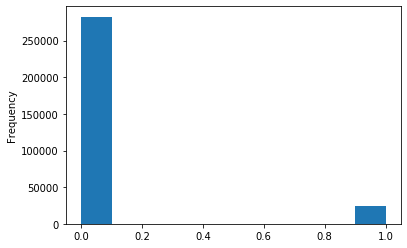

In [0]:
application_train['TARGET'].astype(int).plot.hist()

In [0]:
application_train.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [0]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [0]:
application_train.select_dtypes('object').apply(pd.Series.nunique,axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Encoding categorical data

In [0]:
lbl_enc = LabelEncoder()

for col in application_train:
  if application_train[col].dtype =='object':
    if len(set(application_train[col])) <3:
      application_train[col] = lbl_enc.fit_transform(application_train[col])
      application_test[col] = lbl_enc.transform(application_test[col])

In [0]:
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,...,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train_label = application_train['TARGET']
application_train,application_test = application_train.align(application_test,join = 'inner',axis=1)
application_train['TARGET'] = train_label


### Outlier

In [0]:
application_train.columns.values

array(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAP

In [0]:
(application_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [0]:
(application_train['DAYS_REGISTRATION']/-365).describe()

count    307511.000000
mean         13.660604
std           9.651743
min          -0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64

In [0]:
(application_train['DAYS_ID_PUBLISH']/-365).describe()

count    307511.000000
mean          8.203294
std           4.135481
min          -0.000000
25%           4.712329
50%           8.915068
75%          11.778082
max          19.717808
Name: DAYS_ID_PUBLISH, dtype: float64

In [0]:
(application_train['DAYS_EMPLOYED']).describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

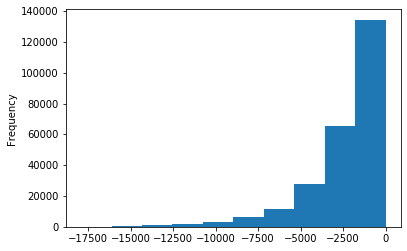

In [0]:
application_train['DAYS_EMPLOYED'].replace({365243 : np.nan},inplace=True)
application_train['DAYS_EMPLOYED'].plot.hist()

In [0]:
corr_data =application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr()

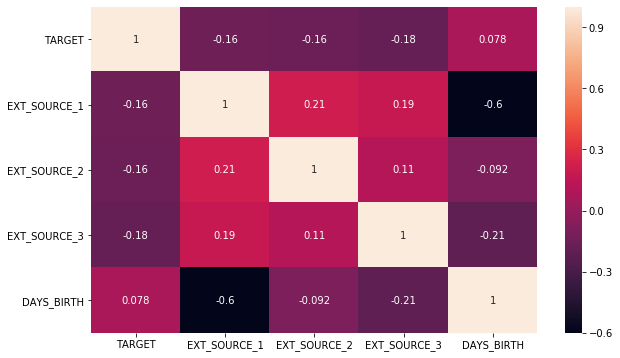

In [0]:
plt.figure(figsize=(10,6))
heat_map = sns.heatmap(corr_data,annot=True)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
bottom, top = heat_map.get_ylim()
heat_map.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### Missing values

In [0]:
train_label = application_train['TARGET']

In [0]:
from sklearn.preprocessing import MinMaxScaler,Imputer

train = application_train.drop(columns=['TARGET'])
test = application_test.copy()

imput = Imputer(strategy='median')
train = imput.fit_transform(train)
test = imput.transform(test)

scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train)
test = scaler.transform(test)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
from sklearn.model_selection import train_test_split
x_train,x_cv,y_train,y_cv = train_test_split(train,train_label,test_size = 0.2,random_state =10)

In [0]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=0.0001)
log_reg.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = log_reg.predict_proba(x_cv)[:, 1]

In [0]:

from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_cv,y_pred)

In [0]:
print(score)

0.6736068358092056


In [0]:
from sklearn.ensemble import RandomForestClassifier
rndm_forest = RandomForestClassifier(n_estimators=100,random_state=10,n_jobs=-1,verbose=1)
rndm_forest.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=10, verbose=1,
                       warm_start=False)

In [0]:
y_pred = rndm_forest.predict_proba(x_cv)[:, 1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.8s finished


In [0]:
score = roc_auc_score(y_cv,y_pred)

In [0]:
print(score)

0.7117747273825975
